# Geoinformatika 

#### Strojové učení v geoinformatice

### Zadání semestrální úlohy 

**Klasifikace Land Cover pomocí rozhodovacího stromu** 

**Cílem** této úlohy je vytvořit a generalizovat rozhodovací strom (Decision Tree, DT) pro klasifikaci land cover na základě daných vstupních dat. Vzhledem k povaze dat bude třeba řešit několik problémů, které ovlivňují výkonnost a interpretaci modelu.

*Popis dat:* 

Vstupní proměnné: Data obsahují různé environmentální a DPZ charakteristiky (např. vegetační indexy, spektrální pásma, nadmořskou výšku, vlhkost půdy aj.).

*Specifika dat*:
- Obsahují šum, což může negativně ovlivnit tvorbu rozhodovacích pravidel.
- Mezi třídami existují překryvy (např. podobnost spektrálních vlastností mezi dvěma typy vegetace), což snižuje přesnost klasifikace.
- Pro dosažení vysoké přesnosti může být vyžadována tvorba hlubokého stromu, který je však náchylný k přeučení na šum nebo irelevantní vzory.

*Cíle úlohy*:
* Naučit rozhodovací strom klasifikovat typy land cover:
* Třídy: les, voda, zemědělská půda, městská zástavba, mokřady.
* Generalizovat model: Minimalizovat přeučení stromu na šum a zlepšit jeho schopnost generalizace na nová, neviděná data. 

### Postup řešení

In [1]:
# Knihovny
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [2]:
# nastavte vlatní hodnotu seed
seed_no = 6

In [3]:
# Počet vzorků
n_samples = 100000

In [4]:
ndvi = np.random.uniform(0, 1, n_samples)
ndwi = np.random.uniform(0, 1, n_samples)
rgb = np.random.uniform(0, 255, (n_samples, 3))
altitude = np.random.uniform(0, 2000, n_samples)
noise = np.random.uniform(0, 1, n_samples)

In [5]:
# Definice třídy na základě překrývajících se pravidel
labels = []
for i in range(n_samples):
    if ndvi[i] > 0.6 and ndwi[i] < 0.3:
        labels.append('les' if np.random.rand() > 0.1 else 'město')  # Přidání šumu
    elif ndvi[i] < 0.3 and ndwi[i] > 0.6:
        labels.append('voda')
    elif rgb[i, 0] > 200:
        labels.append('město')
    else:
        labels.append('trávník')


In [6]:
# Náhodné zamíchání špatných štítků
labels = np.array(labels)
for i in range(int(n_samples * 0.1)):
    labels[np.random.randint(0, n_samples)] = np.random.choice(['les', 'voda', 'město', 'trávník'])


In [7]:
# Vytvoření datové sady
df = pd.DataFrame({
    'NDVI': ndvi,
    'NDWI': ndwi,
    'Red': rgb[:, 0],
    'Green': rgb[:, 1],
    'Blue': rgb[:, 2],
    'Altitude': altitude,
    'Noise': noise,
    'Label': labels
})

In [8]:
# NDVI .. Altitude jsou vstpní proměnné, X
# Label je kategorie Lansd Cover, y

df.head()

x=df.drop("Label", axis=1)
x=x.drop("Noise", axis=1)

y=df["Label"]

### Modelování

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

#výběr trénovacích dat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 166)

clf = tree.DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,   #minimalni pocet vzorku, aby se mohl strom rozrustat
    min_samples_leaf=None
    random_state=16
)

# Trénování modelu
clf.fit(x_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=16)

### Hodnocení modelu

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(x_test)
print("Přesnost klasifikace:")
print(classification_report(y_test, y_pred))

print("Chybová matice:")
print(confusion_matrix(y_test, y_pred))

# Křížová validace - metrika vážené f1 skóre
cv_scores = cross_val_score(clf, x, y, scoring="f1_weighted", cv=5)  # 5 složková křížová validace
print("f1 scores:", cv_scores)
print("Průměrné f1 skóre:", np.mean(cv_scores))


Přesnost klasifikace:
              precision    recall  f1-score   support

         les       0.48      0.84      0.61      3615
       město       0.93      0.73      0.82      5486
     trávník       0.93      0.86      0.89     16879
        voda       0.92      0.85      0.88      4020

    accuracy                           0.83     30000
   macro avg       0.81      0.82      0.80     30000
weighted avg       0.87      0.83      0.84     30000

Chybová matice:
[[ 3022   113   379   101]
 [ 1009  3993   379   105]
 [ 2162   103 14518    96]
 [  169    97   356  3398]]
Cross-validation scores: [0.84351768 0.84276338 0.84399282 0.85125672 0.84732059]
Mean CV accuracy: 0.8457702369318747


### Experimenty pro generalizaci
Práce s parametry: max_features, max_depth a min_samples_leaf

In [ ]:
#seznamy hodnot parametrů pro testování - iterováním přes parametry bude nalezena jejich nejlepší kombinace
max_features_values = [None, "sqrt", "log2"]
max_depth_values = [3, 5, 10, 15, 20]
min_samples_leaf_values = [1, 5, 10, 20]

#Seznamy pro uložení výsledků
f1_train_list = []
f1_test_list = []
parameter_combinations = []

for max_features in max_features_values:
    for max_depth in max_depth_values:
        for min_samples_leaf in min_samples_leaf_values:
            #nastavení modelu a jeho parametrů
            clf = tree.DecisionTreeClassifier(
                max_features=max_features,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )

            #trénink modelu
            clf.fit(x_train, y_train)

            #vytvoření predikcí
            y_train_pred = clf.predict(x_train)
            y_test_pred = clf.predict(x_test)

            #f1 skóre
            cv_scores_train = cross_val_score(clf, x_train, y_train_pred, scoring="f1_weighted", cv=5)
            f1_train = np.mean(cv_scores_train)
            cv_scores_test = cross_val_score(clf, x_test, y_test_pred, scoring="f1_weighted", cv=5)
            f1_test = np.mean(cv_scores_test)

            f1_train_list.append(round(f1_train, 2))
            f1_test_list.append(round(f1_test, 2))
            parameter_combinations.append(f"max_features={max_features}, max_depth={max_depth}, min_samples_leaf={min_samples_leaf}")

            #výsledky
            print(f"max_features: {max_features}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}")
            print(f"F1_train: {f1_train:.3f}, F1_test: {f1_test:.3f}")

max_features: None, max_depth: 3, min_samples_leaf: 1
F1_train: 0.918, F1_test: 0.920
max_features: None, max_depth: 3, min_samples_leaf: 5
F1_train: 0.918, F1_test: 0.920
max_features: None, max_depth: 3, min_samples_leaf: 10
F1_train: 0.918, F1_test: 0.920
max_features: None, max_depth: 3, min_samples_leaf: 20
F1_train: 0.918, F1_test: 0.920


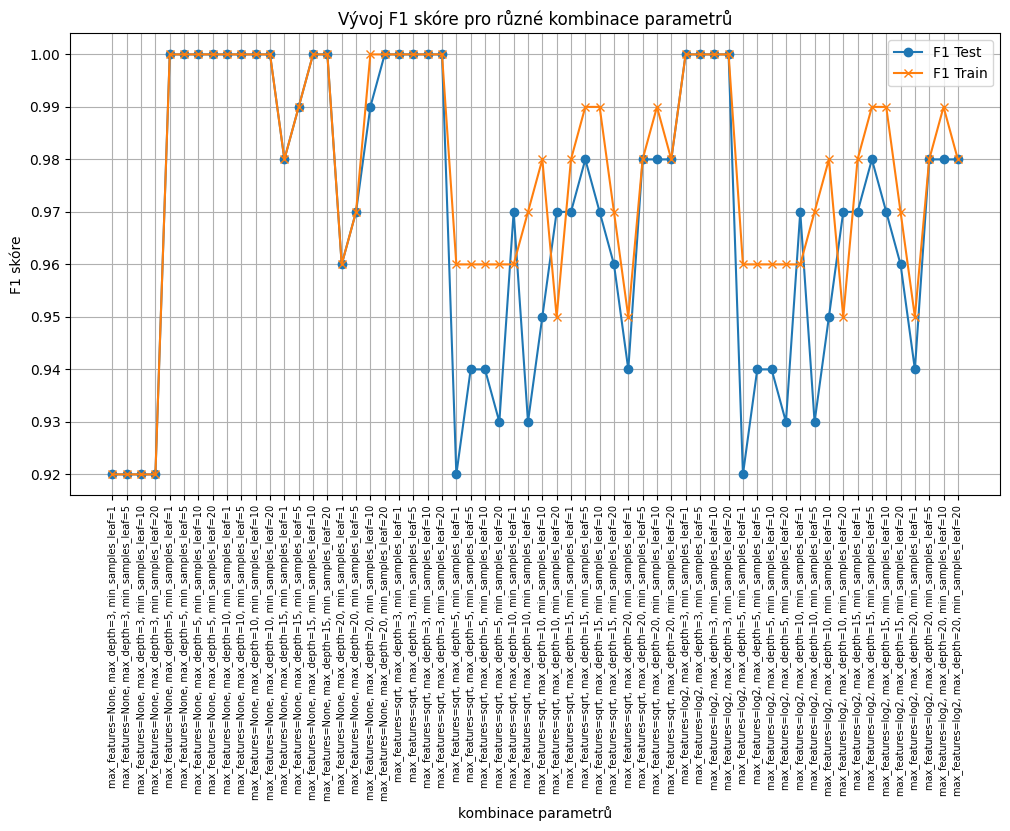

In [28]:
# Vizualizace F1 skóre výsledků
plt.figure(figsize=(12, 6))
plt.plot(parameter_combinations, f1_test_list, label="F1 Test", marker="o")
plt.plot(parameter_combinations, f1_train_list, label="F1 Train", marker="x")
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("kombinace parametrů")
plt.ylabel("F1 skóre")
plt.title("Vývoj F1 skóre pro různé kombinace parametrů")
plt.legend()
plt.grid()
plt.show()

### Výstup úlohy

1. Naučený model rozhodovacího stromu schopný klasifikovat typy land cover s vyváženým poměrem přesnosti a generalizace.
2. Zpráva, která obsahuje:
    - Analýzu generalizace modelu. Citlivost parametrů modelu. 
    - Hodnocení modelu na testovacích datech (přesnost).
    - Diskuzi o problémech s přeučením a šumem a jejich řešeních.

### Zpráva k úloze

- jaký parametr byl nejcitlivější
- hodnocení na testovacích datech - vychází f1 rovno 1 u trénovacích i testovacích :o - divné
- přeučení a šum

In [17]:
pass 

Výsledek Vašeho řešení zašlete do 23.1.2025 na email: lukas.brodsky@natur.cuni.cz 